# Tutorial


This tutorial runs you through the process of running inferences for a deployments in Costa Rica.

In [1]:
import os
os.chdir('/Users/kgoldmann/Documents/Projects/AMBER/amber-inferences')
os.system('pwd')

/Users/kgoldmann/Documents/Projects/AMBER/amber-inferences


0

In [2]:
# Install the package if required
!pip install -e .

Obtaining file:///Users/kgoldmann/Documents/Projects/AMBER/amber-inferences
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for amber_inferences (pyproject.toml) ... done
  Created wheel for amber_inferences: filename=amber_inferences-0.0.1-0.editable-py3-none-any.whl size=5053 sha256=3c05d7d9f73af4944909621c4fa64b8a9c84058b9dd499da5e75728d58d60ea1
  Stored in directory: /private/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/pip-ephem-wheel-cache-142to_qp/wheels/40/0c/a3/d7ea2d909dd0114a7f1a065d1878e0c1a599866e5d26ea1ecb
Successfully built amber_inferences
  Attempting uninstall: amber_inferences
    Found existing installation: amber_inferences 0.0.1
    Uninstalling amber_inferences-0.0.1:
      Successfully uninstalled amber_inferences-0.0.1


In [3]:
import amber_inferences
import boto3
import pandas as pd
from amber_inferences.utils.config import load_credentials
from amber_inferences.utils.api_utils import get_buckets, deployments_summary, get_deployments

# Explore the Data on the Object Store

In [4]:
# Create an instance for the object store
aws_credentials = load_credentials('./credentials.json')
session = boto3.Session(
        aws_access_key_id=aws_credentials["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=aws_credentials["AWS_SECRET_ACCESS_KEY"],
        region_name=aws_credentials["AWS_REGION"],
    )
s3_client = session.client("s3", endpoint_url=aws_credentials["AWS_URL_ENDPOINT"])

Look at the deployments available on the object store:

In [5]:
all_deployments = get_deployments(aws_credentials['UKCEH_username'], aws_credentials['UKCEH_password'])

all_deployments = pd.DataFrame(all_deployments)

List the buckets/countries:

In [6]:
all_deployments[all_deployments['status'] == 'active']

,country,country_code,location_name,lat,lon,location_id,camera_id,system_id,hardware_id,deployment_id,status
30,Costa Rica,cri,Butterfly,9.937355,-84.050435,loc000031,4C2B89AF,sys000031,har000005,dep000031,active
31,Costa Rica,cri,Forest Edge,10.43034,-84.007262,loc000032,EC4AB109,sys000032,har000005,dep000032,active
32,Costa Rica,cri,Swamp,10.432685,-84.008057,loc000033,5794FB2E,sys000033,har000005,dep000033,active
33,Costa Rica,cri,Old Growth,10.432295,-84.010643,loc000034,E601A49B,sys000034,har000005,dep000034,active
34,Costa Rica,cri,Dry Forest,10.34498,-85.339332,loc000035,1C5084E2,sys000035,har000005,dep000035,active
...,...,...,...,...,...,...,...,...,...,...,...
98,Anguilla,aia,Prickly pear,18.264,-63.174,loc000083,CE2D5147,sys000089,string,dep000099,active
99,Anguilla,aia,Sombrero,18.587,-63.426,loc000084,A382FC9E,sys000090,string,dep000100,active
100,Anguilla,aia,Dog,string,string,loc000085,8439CBD2,sys000091,string,dep000101,active
101,United Kingdom,gbr,Rolls Royce,52.909863,-1.434043,loc000086,string,sys000092,string,dep000102,active


Let's pick one, cri (Costa Rica) and check out the data attached. 

In [7]:
cr_deployments = deployments_summary(
    aws_credentials,
    subset_countries=["Costa Rica"],
    subset_deployments=["dep000031", "dep000032"],
    include_image_count=False
)

To get the files for a given deployment(s):

In [8]:
cr_deployments

{'dep000031': {'country': 'Costa Rica',
  'country_code': 'cri',
  'location_name': 'Butterfly',
  'lat': '9.937355',
  'lon': '-84.050435',
  'location_id': 'loc000031',
  'camera_id': '4C2B89AF',
  'system_id': 'sys000031',
  'hardware_id': 'har000005',
  'deployment_id': 'dep000031',
  'status': 'active'},
 'dep000032': {'country': 'Costa Rica',
  'country_code': 'cri',
  'location_name': 'Forest Edge',
  'lat': '10.43034',
  'lon': '-84.007262',
  'location_id': 'loc000032',
  'camera_id': 'EC4AB109',
  'system_id': 'sys000032',
  'hardware_id': 'har000005',
  'deployment_id': 'dep000032',
  'status': 'active'}}

# Log the image keys

In [9]:
from amber_inferences.utils.key_utils import save_keys

In [10]:
# takes some time to commenting out to save time
# save_keys(
#     s3_client,
#     bucket="cri",
#     deployment_id="dep000031",
#     output_file="./examples/dep000031_keys.json",
#     subdir="snapshot_images"
# )

In [11]:
# Look at the keys
!head ./examples/dep000031_keys.json

[
    "dep000031/snapshot_images/01-20240131183130-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131183320-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131183510-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131183700-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131183720-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131183850-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131184040-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131184230-snapshot.jpg",
    "dep000031/snapshot_images/01-20240131184420-snapshot.jpg",


# Download the images

In [12]:
import json
from amber_inferences.utils.inference_scripts import download_image_from_key

In [13]:
# read the first image in the keys file and open
with open('./examples/dep000031_keys.json') as f:
    keys = json.load(f)

In [14]:
for i in range(100, 110):
    download_image_from_key(s3_client, keys[i], 'cri', './examples/images/dep000031/')

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [16]:
image_paths = os.listdir('./examples/images/dep000031/')
image_paths = [os.path.join('./examples/images/dep000031/', x) for x in image_paths]

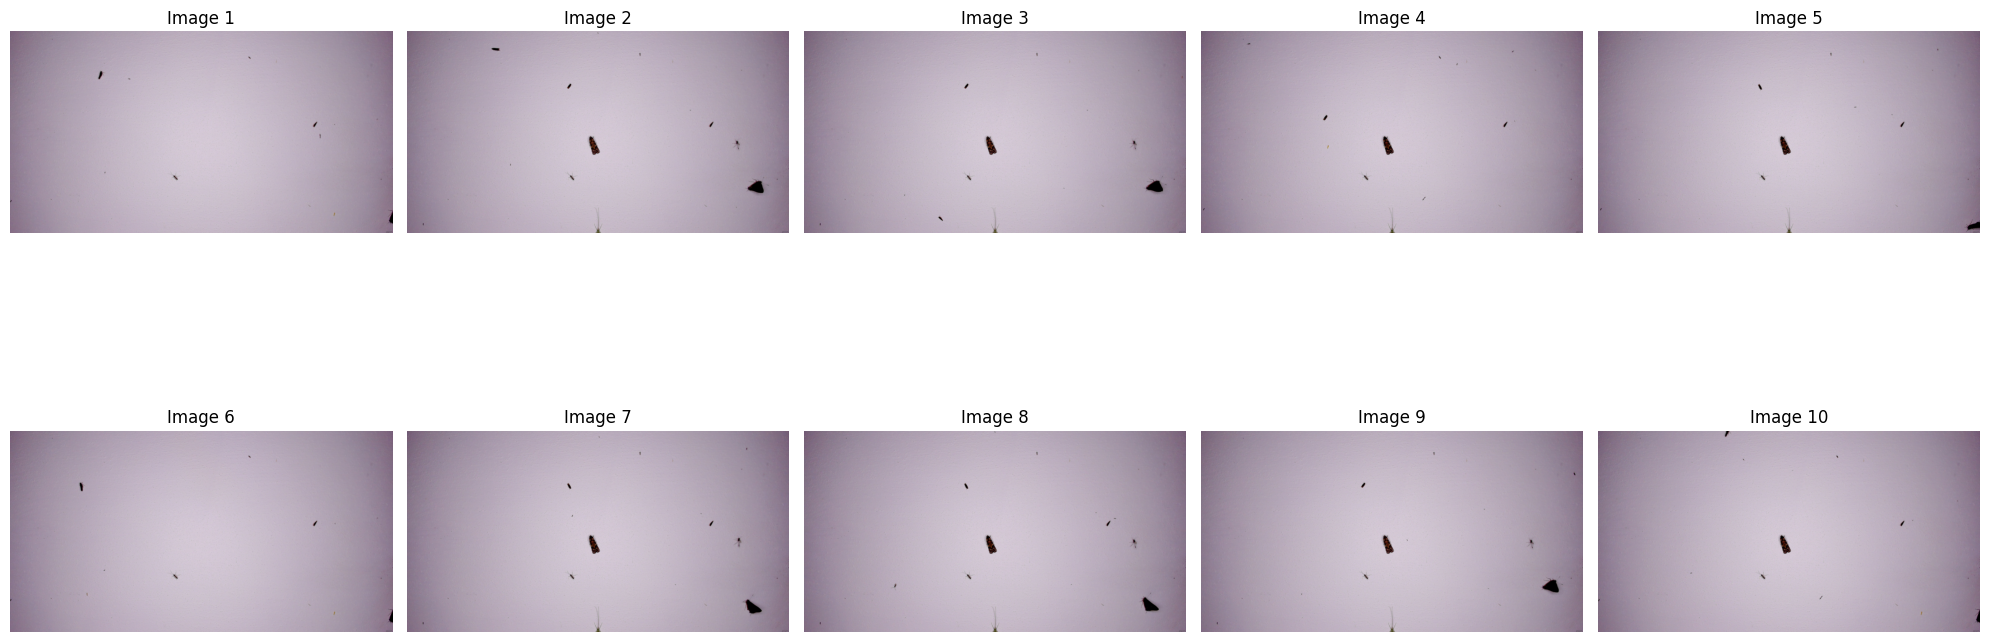

In [17]:
# Open the images in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()

for i, img_path in enumerate(image_paths):
    if os.path.exists( img_path):  # Ensure the file exists
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis("off")  # Hide axes for better visualization
        axs[i].set_title(f"Image {i+1}")
    else:
        axs[i].axis("off")
        axs[i].set_title("Missing Image")

plt.tight_layout()
plt.show()

# Perform Object Detection on the Images

In [18]:
from amber_inferences.utils.custom_models import *
from amber_inferences.utils.inference_scripts import *
import torch

/Users/kgoldmann/amber/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
models = load_models(
    device=torch.device("cpu"),
    localisation_model_path='./models/v1_localizmodel_2021-08-17-12-06.pt'
)

In [ ]:
# !pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.3 MB/s eta 0:00:00a 0:00:01


In [ ]:
crops = crop_image_only(
    image_path='./examples/images/dep000031/01-20240131213830-snapshot.jpg',
    bucket_name="cri",
    localisation_model=models['localisation_model'],
    proc_device=torch.device("cpu"),
    csv_file="./examples/dep000031_crops.csv",
    save_crops=True,
    box_threshold=0.1,
    crop_dir="./examples/crops/dep000031",
    job_name=None,
)

In [89]:
crops

,image_path,image_datetime,bucket_name,analysis_datetime,job_name,image_bluriness,crop_status,box_score,box_label,x_min,y_min,x_max,y_max,crop_bluriness,crop_area,cropped_image_path
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 0,tensor(0.9993),tensor(1),1909.180833,1126.064905,2094.860625,1349.414539,162.527854,4.147151e+04,./examples/crops/dep000031/01-20240131213830-s...
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 1,tensor(0.9711),tensor(1),62.290312,5.250037,3886.277917,2160.000000,15.319809,8.239737e+06,./examples/crops/dep000031/01-20240131213830-s...
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 2,tensor(0.8511),tensor(1),3923.820833,2028.911353,4096.000000,2157.670898,10936.628832,2.216971e+04,./examples/crops/dep000031/01-20240131213830-s...
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 3,tensor(0.2450),tensor(1),54.871094,0.000000,904.733750,2160.000000,15.846736,1.835703e+06,./examples/crops/dep000031/01-20240131213830-s...
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 4,tensor(0.2198),tensor(1),101.476016,0.000000,1872.838333,2160.000000,16.323450,3.826143e+06,./examples/crops/dep000031/01-20240131213830-s...
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 17:40:34,None,42.218197,crop 5,tensor(0.1025),tensor(1),8.391992,2.434999,221.360469,247.210757,22.419706,5.212952e+04,./examples/crops/dep000031/01-20240131213830-s...


annotate the input image with the bounding boxes

In [21]:
# read in the csv file
crops = pd.read_csv('./examples/dep000031_crops.csv')
crops

,image_path,image_datetime,bucket_name,analysis_datetime,job_name,crop_status,box_score,box_label,x_min,y_min,x_max,y_max,cropped_image_path
0,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 0,tensor(0.9993),tensor(1),1909.180833,1126.064905,2094.860625,1349.414539,NaN
1,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 1,tensor(0.9711),tensor(1),62.290312,5.250037,3886.277917,2160.000000,./examples/crops/dep000031/01-20240131213830-s...
2,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 2,tensor(0.8511),tensor(1),3923.820833,2028.911353,4096.000000,2157.670898,./examples/crops/dep000031/01-20240131213830-s...
3,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 3,tensor(0.2450),tensor(1),54.871094,0.000000,904.733750,2160.000000,./examples/crops/dep000031/01-20240131213830-s...
4,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 4,tensor(0.2198),tensor(1),101.476016,0.000000,1872.838333,2160.000000,./examples/crops/dep000031/01-20240131213830-s...
5,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,crop 5,tensor(0.1025),tensor(1),8.391992,2.434999,221.360469,247.210757,./examples/crops/dep000031/01-20240131213830-s...
6,/Users/kgoldmann/Documents/Projects/AMBER/ambe...,2024-01-31 21:38:03,cri,2025-03-21 16:56:01,NaN,NO DETECTIONS FOR IMAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# annotate the image with the bounding boxes
from PIL import Image
from PIL import ImageDraw

def image_annotation(image_path, img=None, boxes={}):
    if img is None:
        img = Image.open(image_path)

    draw = ImageDraw.Draw(img)
    for box in boxes:
        x0 = box['x_min']
        y0 = box['y_min']
        x1 = box['x_max']
        y1 = box['y_max']
        draw.rectangle([x0, y0, x1, y1], outline='red', width=3)

        if 'label' in box.keys():
            draw.text((x0, y0), box['label'], fill='red')

    plt.imshow(img)



<!-- python3 -m amber_inferences.cli.perform_inferences \
  --chunk_id 10 \
  --json_file '../examples/dep000022_keys.json' \
  --output_dir '../data/examples/dep000022' \
  --bucket_name 'pan' \
  --credentials_file '../credentials.json' \
  --csv_file '../data/examples/dep000022.csv' \
  --species_model_path ../models/turing-costarica_v03_resnet50_2024-06-04-16-17_state.pt \
  --species_labels ../models/03_costarica_data_category_map.json \
  --binary_model_path ../models/moth-nonmoth-effv2b3_20220506_061527_30.pth \
  --localisation_model_path ../models/v1_localizmodel_2021-08-17-12-06.pt \
  --order_model_path ../models/dhc_best_128.pth \
  --order_thresholds_path ../models/thresholdsTestTrain.csv \
  --perform_inference \
  --box_threshold 0.99 \
  --save_crops -->